**BERT (Bidirectional Encoder Representations from Transformers) model for Emotion detection**



In [1]:
# Install Required Libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

import torch
from transformers import BertTokenizer, BertForMaskedLM
from transformers import BertConfig

In [ ]:
# setting path for repo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading dataset
# Importing train, validation and test datasets with preprocessed texts and labels
train_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/train_data.csv")
val_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/val_data.csv")
test_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/test_data.csv")

# Shape validation
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

# Defining the emotion columns
emotion = ['anger', 'fear', 'joy', 'sadness', 'surprise']

(2214, 6)
(276, 7)
(278, 7)


In [ ]:
# Define features and labels
texts = train_data['clean_text'].tolist()
labels = train_data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values

In [ ]:
# Computing max length of samples
full_text = pd.concat([train_data['clean_text'], val_data['clean_text'], test_data['clean_text']])
max_length = full_text.apply(lambda x: len(x.split())).max()
max_length

86

In [ ]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [ ]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
def tokenize_data(texts, labels, tokenizer, max_len=128):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
    return inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels)

train_inputs, train_masks, train_labels = tokenize_data(train_texts, train_labels, tokenizer)
val_inputs, val_masks, val_labels = tokenize_data(val_texts, val_labels, tokenizer)

In [ ]:
# Load and Preprocess the Dataset

from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [ ]:
# Create DataLoader
batch_size = 16
train_data = EmotionDataset(train_inputs, train_masks, train_labels)
val_data = EmotionDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Define a Custom Dataset and DataLoader

from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [ ]:
# Create DataLoader
batch_size = 16
train_data = EmotionDataset(train_inputs, train_masks, train_labels)
val_data = EmotionDataset(val_inputs, val_masks, val_labels)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the BERT Model for Multi-label Classification

import torch
from torch import nn
from transformers import BertModel

class BertForEmotionClassification(nn.Module):
    def __init__(self, num_labels):
        super(BertForEmotionClassification, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
# Define Training and Evaluation Loops
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Initialize model
model = BertForEmotionClassification(num_labels=5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForEmotionClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [ ]:
# Optimizer and Loss
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()  # For multi-label classification


In [ ]:
# Train Function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader)

In [ ]:
# Evaluate Function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store predictions and true labels
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            predictions.append(preds)
            true_labels.append(labels.cpu().numpy())
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)

    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='micro')

    return total_loss / len(dataloader), accuracy, f1

Training the model for five epochs and check the F1 scores

In [ ]:
# Train the Model and save the weights

import csv

# Create lists to store the results for each epoch
epoch_results = []

# Training loop
epochs = 5
for epoch in range(epochs):
    # Train model
    train_loss = train_model(model, train_dataloader, optimizer, criterion, device)

    # Evaluate model
    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dataloader, criterion, device)

    # Print the output for each epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")

    # Save the results for the current epoch
    epoch_results.append([epoch + 1, train_loss, val_loss, val_accuracy, val_f1])

# Save results to a CSV file after training
with open('./drive/MyDrive/ColabNotebooks/semeval_project/epoch_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Val Accuracy', 'Val F1 Score'])  # header row
    writer.writerows(epoch_results)  # write the collected results

print("Training results saved to 'epoch_results.csv'.")


Epoch 1/5
Train Loss: 0.5877
Val Loss: 0.5192, Val Accuracy: 0.1783, Val F1 Score: 0.5217
Epoch 2/5
Train Loss: 0.4846
Val Loss: 0.4627, Val Accuracy: 0.3341, Val F1 Score: 0.5910
Epoch 3/5
Train Loss: 0.4011
Val Loss: 0.4058, Val Accuracy: 0.4108, Val F1 Score: 0.6888
Epoch 4/5
Train Loss: 0.3279
Val Loss: 0.3864, Val Accuracy: 0.4334, Val F1 Score: 0.6980
Epoch 5/5
Train Loss: 0.2733
Val Loss: 0.3827, Val Accuracy: 0.4560, Val F1 Score: 0.7105
Training results saved to 'epoch_results.csv'.


In [ ]:
# Save and Use the Model for Predictions

# Save the model
torch.save(model.state_dict(), "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model.pth")

# Load the model for inference
model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model.pth"))


<ipython-input-23-702c2c274908>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_cla

<All keys matched successfully>

In [ ]:
# progress of F1 score at each step
import matplotlib.pyplot as plt

# Initialize lists to store metrics
train_losses = [0.5904, 0.4984, 0.4173, 0.2051, 0.1694]
val_losses = [0.5295, 0.4619, 0.4098, 0.3809, 0.3811]
val_f1_scores = [0.4775, 0.6265, 0.6905, 0.7234, 0.7531] # for each epoch

# 0.3454, 0.2922, 0.2443, 0.2051, 0.1694
# , 0.3859, 0.3799, 0.3739, 0.3809, 0.3811
# , 0.7108, 0.7135, 0.7348, 0.7234, 0.7531

# Training loop with F1 score tracking
epochs = 5
for epoch in range(epochs):
    train_loss = train_model(model, train_dataloader, optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dataloader, criterion, device)

    # Append metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")


KeyboardInterrupt: 

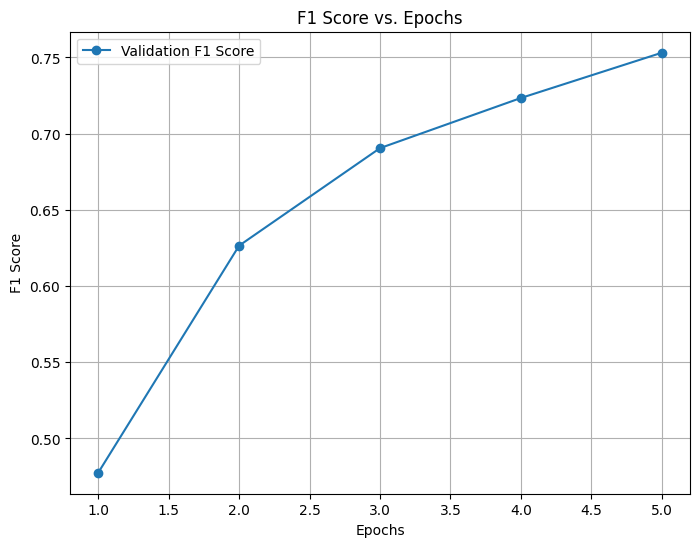

In [ ]:
# progress of F1 score at each step
import matplotlib.pyplot as plt
# Plot F1 Score across epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), val_f1_scores, marker='o', label='Validation F1 Score')
plt.title("F1 Score vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model.pth")

# Load the model for inference
model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model.pth"))

<ipython-input-21-c7afc0e8087a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_cla

<All keys matched successfully>

BERT model output testing

In [ ]:
# Inference
def predict_emotions(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(inputs['input_ids'], inputs['attention_mask'])
        probs = torch.sigmoid(outputs).cpu().numpy()
    return probs > 0.5

text = "I can not see anything."
predicted_emotions = predict_emotions(text, model, tokenizer, device)
print("Predicted Emotions:", predicted_emotions)

Predicted Emotions: [[ True  True False False  True]]


In [ ]:
# To see the output in emotion name format
def predict_emotions_with_details(text, model, tokenizer, emotion_labels, device):
    """
    Predict emotions for a given text with details.
    Returns the predicted emotions, binary outputs, and probabilities.
    """
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # Remove token_type_ids if not required by the model
    if "token_type_ids" in inputs:
        del inputs["token_type_ids"]

    with torch.no_grad():
        outputs = model(**inputs)  # Use model inputs
        logits = outputs.logits if hasattr(outputs, "logits") else outputs  # Handle plain tensor outputs
        probs = torch.sigmoid(logits).cpu().numpy()[0]  # Convert logits to probabilities

    # Determine binary outputs (True/False) based on a threshold
    binary_outputs = probs > 0.5

    # Map True/False to emotion labels
    predicted_emotion = [emotion for emotion, binary in zip(emotion_labels, binary_outputs) if binary]

    return predicted_emotion, binary_outputs, probs



In [ ]:
# One by one model testing
text = "I can not see anything."
emotion_labels = ["anger", "fear", "joy", "sadness", "surprise"]

predicted_emotion, binary_outputs, probabilities = predict_emotions_with_details(
    text, model, tokenizer, emotion_labels, device
)

print("Predicted Emotion(s):", predicted_emotion)
print("Binary Outputs (True/False):", binary_outputs)
print("Probabilities:", probabilities)

Predicted Emotion(s): ['anger', 'fear', 'surprise']
Binary Outputs (True/False): [ True  True False False  True]
Probabilities: [0.56604034 0.5862251  0.42404246 0.38055438 0.5576809 ]


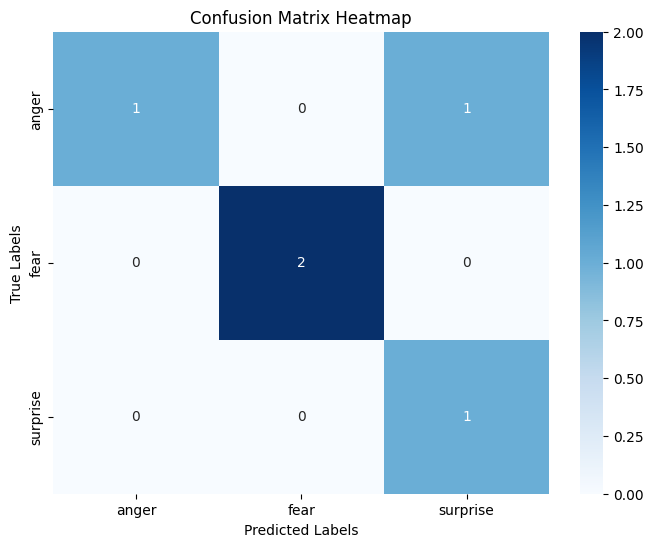

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.50      0.67         2
        fear       1.00      1.00      1.00         2
    surprise       0.50      1.00      0.67         1

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.78         5
weighted avg       0.90      0.80      0.80         5



In [ ]:
# Evaluation with heat map
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_test and y_pred are available
y_test = [0, 1, 1, 0, 2]  # True labels (example)
y_pred = [0, 1, 1, 2, 2]  # Predicted labels from the model

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
#labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']
labels = ['anger', 'fear', 'surprise']

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels))




Fine Tuning the BERT Model with different methods:

In [ ]:
# Fine-tune the BERT Model

In [ ]:
from transformers import BertForSequenceClassification
import torch

# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replace with your Hugging Face repo name (public or private)
model_name = "bert-base-uncased"  # Or your custom Hugging Face repo ID
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch
from transformers import BertForSequenceClassification, BertConfig

# Specify the path to your local directory with the model
model_path = "./drive/MyDrive/ColabNotebooks/semeval_project/"
config = BertConfig.from_pretrained(model_path, num_labels=5)
#model = BertForSequenceClassification.from_pretrained(model_path, config=config)
model.to(device)

import torch
from transformers import BertConfig, BertForSequenceClassification

# Initialize model with config
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=5)
model = BertForSequenceClassification(config)

# Load weights
model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model.pth"))
model.to(device)


<ipython-input-22-e4bb9e2d3dc0>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_cl

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

1. By changing the learning rate

In [ ]:
# 1. Fine-tune entire BERT model

from torch.optim import AdamW
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()  # Convert labels to float

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Extract logits from SequenceClassifierOutput

            # Debugging print statement
            print(f"logits shape: {logits.shape}, labels shape: {labels.shape}")

            # Compute the loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute predictions
            predictions = torch.sigmoid(logits) > 0.5  # Convert logits to binary predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute average loss
    avg_loss = total_loss / len(dataloader)

    # Compute accuracy and F1 score
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    return avg_loss, accuracy, f1



In [ ]:
# Training loop
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
for epoch in range(epochs):
    train_loss = train_model(model, train_dataloader, optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dataloader, criterion, device)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")

     #Key Details
      #Learning Rate: A small learning rate (e.g., 2e-5) is used to ensure gradual updates.
      #When to Use: Use this when you have sufficient data to train all layers without overfitting.


logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]),

In [ ]:
# Save the model
torch.save(model.state_dict(), "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_full.pth")

# Load the model for inference
model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_full.pth"))

<ipython-input-40-10eea74c3010>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_cla

<All keys matched successfully>

2. By making changes in specific layers

In [ ]:
# 2. Fine-tune Specific Layers

def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()  # Convert labels to float

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Extract logits from SequenceClassifierOutput

            # Debugging print statement
            print(f"logits shape: {logits.shape}, labels shape: {labels.shape}")

            # Compute the loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute predictions
            predictions = torch.sigmoid(logits) > 0.5  # Convert logits to binary predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute average loss
    avg_loss = total_loss / len(dataloader)

    # Compute accuracy and F1 score
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    return avg_loss, accuracy, f1



In [ ]:
# 2. Fine-tune Specific Layers
# Freeze all layers except the top few
for param in model.bert.parameters():
    param.requires_grad = False

# Unfreeze top few layers
for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    train_loss = train_model(model, train_dataloader, optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dataloader, criterion, device)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")

    # Key Details
      #Layer Selection: Only the last two transformer layers and the classifier head are fine-tuned.
      #When to Use: Use this approach when you have a small dataset to avoid overfitting while leveraging BERT's pre-trained capabilities.


logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]), labels shape: torch.Size([16, 5])
logits shape: torch.Size([16, 5]),

In [ ]:
# Save the model
torch.save(model.state_dict(), "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_layer.pth")

# Load the model for inference
model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_layer.pth"))

<ipython-input-39-7532953eb598>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./drive/MyDrive/ColabNotebooks/semeval_project/emotion_cla

<All keys matched successfully>

In [ ]:
# Comparison of Approaches
#Feature	      Full Fine-tuning	                Partial Fine-tuning
#Training Time	Longer	                          Shorter
#Memory Usage	  Higher	                          Lower
#Flexibility	  High (all layers train)	          Moderate (specific layers)
#Overfitting    Risk	Higher	                    Lower

By using ROBERTa model

In [ ]:
for batch in train_loader:
    print(f"Input IDs shape: {batch['input_ids'].shape}")  # Should be [80, seq_length]
    print(f"Labels shape: {batch['labels'].shape}")  # Should be [80]
    break


Input IDs shape: torch.Size([80, 95])
Labels shape: torch.Size([80, 5])


In [ ]:
print(f"Labels shape: {labels.shape}")

Labels shape: (2214, 5)


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            # Debugging shape of labels
            print(f"Logits shape: {model(input_ids, attention_mask=attention_mask).logits.shape}")
            print(f"Labels shape: {labels.shape}")

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")


In [ ]:
for batch in train_loader:
    print(batch[0].shape)  # input_ids shape
    print(batch[1].shape)  # attention_mask shape
    print(batch[2].shape)  # labels shape


torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Size([16, 94])
torch.Size([16, 94])
torch.Size([16, 5])
torch.Si

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch

# Load the RoBERTa tokenizer and model
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(emotion_labels))

# Define optimizer and device
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare your dataset
def encode_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    # Convert labels to a PyTorch tensor of the correct type and shape
    labels_tensor = torch.tensor(labels, dtype=torch.float32) # Changed to float32 and kept 2D for multi-label

    dataset = torch.utils.data.TensorDataset(
        encodings["input_ids"],
        encodings["attention_mask"],
        labels_tensor  # Use the 2D labels tensor
    )
    return dataset

# Reload the data to avoid using overwritten or stale versions (if necessary)
train_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/train_data.csv")
val_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/val_data.csv")
test_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/test_data.csv")

texts = train_data['clean_text'].tolist()  # Assuming this holds your text data
labels = train_data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values  # Assuming this is your emotion label data

# Split your dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Ensure labels are numerical before encoding
# (If they are not already, adjust accordingly)

train_dataset = encode_data(train_texts, train_labels, tokenizer)
val_dataset = encode_data(val_texts, val_labels, tokenizer)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Define training loop
def train_model(model, train_loader, val_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            # The change is in this line: using BCEWithLogitsLoss for multi-label
            outputs = model(input_ids, attention_mask=attention_mask)
            loss_fct = torch.nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multi-label classification
            loss = loss_fct(outputs.logits, labels) # Calculate loss directly on logits and 2D labels

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

        # Validate the model (updated for multi-label)
        model.eval()
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                predictions = torch.sigmoid(outputs.logits) > 0.5  # Apply sigmoid and threshold for multi-label
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate accuracy (example - adjust as needed for multi-label)
        f1 = f1_score(all_labels, all_predictions, average="weighted")
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f"Validation Accuracy: {accuracy:.2f}")
        print(f"Validation F1 Score: {f1:.2f}")
        model.train()

# Train the RoBERTa model
train_model(model, train_loader, val_loader, optimizer, device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Save the model
torch.save(model.state_dict(), "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_ROBERTA.pth")

By using ALBERT model


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch


# Load the ALBERT tokenizer and model
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=len(emotion_labels))

# Define optimizer and device
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Prepare your dataset
def encode_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    # Convert labels to a PyTorch tensor of the correct type and shape
    # We need labels as a 2D tensor for multi-label classification
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    dataset = TensorDataset(
        encodings["input_ids"],
        encodings["attention_mask"],
        labels_tensor  # Using 2D labels tensor
    )
    return dataset

# Reload the data to avoid using overwritten or stale versions (if necessary)
train_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/train_data.csv")
val_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/val_data.csv")
test_data = pd.read_csv("./drive/MyDrive/ColabNotebooks/semeval_project/test_data.csv")

texts = train_data['clean_text'].tolist()
labels = train_data[['anger', 'fear', 'joy', 'sadness', 'surprise']].values

# Split your dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_dataset = encode_data(train_texts, train_labels, tokenizer)
val_dataset = encode_data(val_texts, val_labels, tokenizer)

# Define DataLoaders with batch size 80
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Reduced batch size
val_loader = DataLoader(val_dataset, batch_size=16)  # Reduced batch size

# Define training loop
def train_model(model, train_loader, val_loader, optimizer, device, epochs=3):
    criterion = torch.nn.BCEWithLogitsLoss() # Define loss function for multi-label
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)  # Calculate loss using BCEWithLogitsLoss

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

        # Validate the model (updated for multi-label)
        model.eval()
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                outputs = model(input_ids, attention_mask=attention_mask)
                predictions = torch.sigmoid(outputs.logits) > 0.5  # Apply sigmoid and threshold for multi-label
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate accuracy and F1 score
        accuracy = accuracy_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions, average="weighted")
        print(f"Validation Accuracy: {accuracy:.2f}")
        print(f"Validation F1 Score: {f1:.2f}")
        model.train()  # Set back to train mode for the next epoch

# Train the ALBERT model
train_model(model, train_loader, val_loader, optimizer, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.5589265434054641
Validation Accuracy: 0.19
Validation F1 Score: 0.38
Epoch 2, Loss: 0.4828975729577176
Validation Accuracy: 0.35
Validation F1 Score: 0.61
Epoch 3, Loss: 0.42030868283263195
Validation Accuracy: 0.37
Validation F1 Score: 0.65


In [ ]:
# Save the model
torch.save(model.state_dict(), "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_ALBERT.pth")

Explainability analysis of model by performing SHAP.

In [ ]:
!pip install shap transformers

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Assuming your model and tokenizer are loaded as 'model' and 'tokenizer'
# Ensure model is in evaluation mode
model.eval()

# Assuming your emotion labels are stored in 'emotion_labels'
explainer_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1  # Use -1 for CPU
)

# Create a SHAP explainer with a Text masker
# Use 'partition' algorithm for text data, providing the tokenizer
explainer = shap.Explainer(
    explainer_pipeline,
    masker=shap.maskers.Text(tokenizer),
    algorithm="partition",  # Recommended for text data
)

# Choose some random samples from the validation set
random_indices = np.random.choice(len(val_texts), 5, replace=False)
sample_texts = [val_texts[i] for i in random_indices]

# Generate SHAP values
shap_values = explainer(sample_texts)

# Plot SHAP values for each sample
for i, text in enumerate(sample_texts):
    print(f"Text {i + 1}: {text}")
    shap.plots.text(shap_values[i], display=False)
    plt.show()  # Show each plot immediately

Device set to use cpu
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [02:42<00:55, 27.83s/it]

  0%|          | 0/90 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [02:53<00:20, 20.42s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:58<00:00, 14.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [04:45, 57.03s/it]


Text 1: i was just crying so hard that the tears dripped off my chin and into the sink
Text 2: i closed my eyes and tried my best to ignore it and i eventually ended up falling asleep
Text 3: and then my cheeks get even redder
Text 4: yes my belly is getting big
Text 5: it is friday night i am home in my jammies watching something stupid on tv with my legs all covered up like a good girl


  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:51<00:53, 26.59s/it]

  0%|          | 0/90 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [02:00<00:19, 19.22s/it]

  0%|          | 0/56 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:06<00:00, 14.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [03:47, 45.58s/it]


IndexError: list index out of range

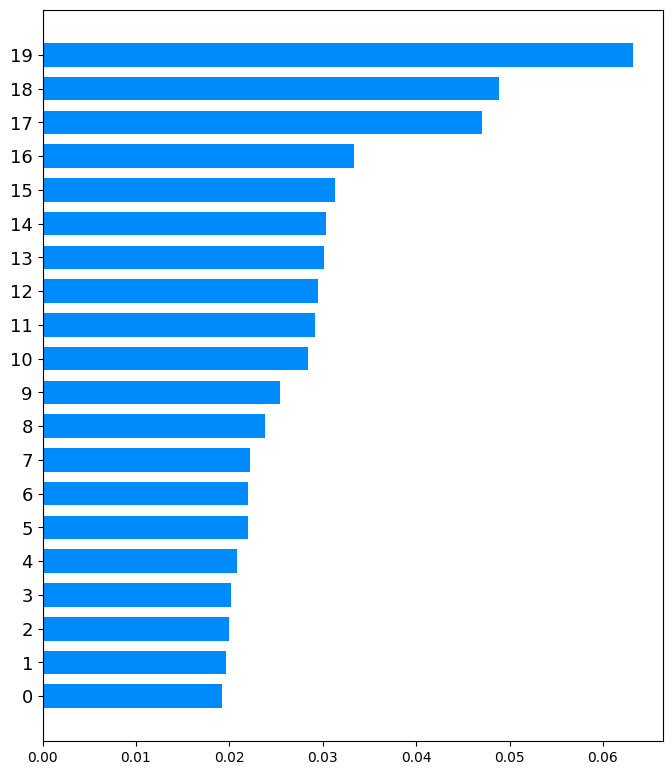

In [ ]:
# Generate SHAP values
shap_values = explainer(sample_texts)

# Get the maximum number of words across all samples
max_words = max(len(sv.values) for sv in shap_values)

# Pad SHAP values with zeros to ensure consistent shape
shap_values_array = np.zeros((len(sample_texts), max_words, shap_values[0].values.shape[1]))  # Initialize with zeros
for i, sv in enumerate(shap_values):
    shap_values_array[i, :len(sv.values), :] = sv.values  # Fill with actual SHAP values

# Reshape to (samples, classes * words) for summary plot
shap_values_array = shap_values_array.reshape(len(sample_texts), -1)

# Create the summary plot using the reshaped array
shap.summary_plot(shap_values_array,
                  feature_names=sample_texts,
                  plot_type="bar")

  0%|          | 0/342 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [02:01<00:44, 22.39s/it]

  0%|          | 0/90 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:12<00:00, 11.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [03:38, 43.71s/it]


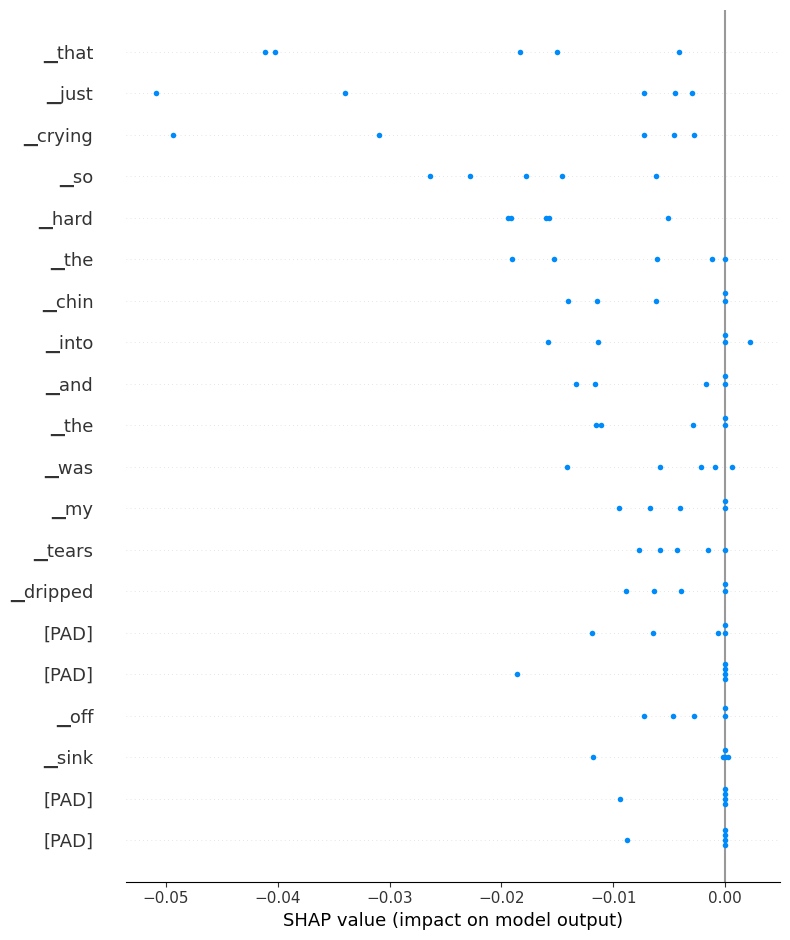

In [ ]:
import numpy as np

# Initialize the explainer and compute SHAP values
shap_values = explainer(sample_texts)

# Ensure we are working with multi-class SHAP values
class_index = 0  # Adjust as needed for a specific class

# Extract SHAP values for the specific class for each sample
shap_values_for_class = [
    shap_values[i].values[:, class_index] for i in range(len(sample_texts))
]

# Find the maximum sequence length among SHAP values
max_length = max(len(values) for values in shap_values_for_class)

# Pad SHAP values to the maximum length
padded_shap_values = np.array([
    np.pad(values, (0, max_length - len(values)), mode='constant', constant_values=0)
    for values in shap_values_for_class
])

# Generate feature names from the tokenizer output
tokenized_texts = [tokenizer.tokenize(text) for text in sample_texts]

# Flatten the tokenized texts and pad to the maximum length for visualization
flattened_features = [
    tokens + ["[PAD]"] * (max_length - len(tokens)) for tokens in tokenized_texts
]

# Flatten the padded features for SHAP visualization
flattened_features = np.concatenate(flattened_features)

# Plot SHAP summary
shap.summary_plot(
    padded_shap_values,
    feature_names=flattened_features[:max_length],  # Limit to max length
    class_names=emotion_labels  # Adjust for your emotion labels
)




In [ ]:
# Train Function
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        # The change is in this line: outputs is directly the logits now
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader)

In [ ]:
# Update evaluate_model similarly
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)

            # Change here: outputs is now the logits directly
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store predictions and true labels
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5  # Assuming you want sigmoid for multi-label
            predictions.append(preds)
            true_labels.append(labels.cpu().numpy())

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)  # Convert labels to float if needed

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Extract logits from SequenceClassifierOutput

            # Compute the loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute predictions (multi-label classification)
            probs = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities
            preds = probs > 0.5  # Apply a threshold to get binary predictions
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics after the loop
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')  # Choose the appropriate average

    # Return the calculated values
    return total_loss / len(dataloader), accuracy, f1

In [ ]:
# 3.Add a Custom Classifier on Top of BERT

from torch import nn

# Define BERT model with a custom classifier
class BertWithCustomClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertWithCustomClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, 128)  # Hidden layer
        self.output_layer = nn.Linear(128, num_labels)  # Output layer

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        hidden_output = nn.ReLU()(self.hidden_layer(pooled_output))
        logits = self.output_layer(hidden_output)
        return logits

# Instantiate and move to device
model = BertWithCustomClassifier(num_labels=5)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 1
for epoch in range(epochs):
    train_loss = train_model(model, train_dataloader, optimizer, criterion, device)
    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dataloader, criterion, device)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")

    #Key Details
      # Added a hidden layer with ReLU activation to capture non-linear relationships.
      # Dropout is used to reduce overfitting.

AttributeError: 'Tensor' object has no attribute 'logits'

In [ ]:
# Multi-task Learning with Auxiliary Tasks
# Fine-tune BERT on an auxiliary task alongside your main task to improve generalization. For example, you could predict emotion labels and reconstruct input text simultaneously.

class BertForMultiTaskLearning(nn.Module):
    def __init__(self, num_labels):
        super(BertForMultiTaskLearning, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.emotion_classifier = nn.Linear(self.bert.config.hidden_size, num_labels)  # Emotion classification
        self.reconstruction_layer = nn.Linear(self.bert.config.hidden_size, self.bert.config.vocab_size)  # Reconstruction

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.pooler_output)
        sequence_output = outputs.last_hidden_state

        # Emotion classification
        emotion_logits = self.emotion_classifier(pooled_output)

        # Reconstruction task
        reconstructed_logits = self.reconstruction_layer(sequence_output)

        return emotion_logits, reconstructed_logits

# Instantiate and move to device
model = BertForMultiTaskLearning(num_labels=5)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Multi-task Loss
def multitask_loss_fn(emotion_logits, emotion_labels, reconstructed_logits, input_ids):
    classification_loss = criterion(emotion_logits, emotion_labels)
    reconstruction_loss = nn.CrossEntropyLoss()(reconstructed_logits.view(-1, reconstructed_logits.size(-1)), input_ids.view(-1))
    return classification_loss + 0.5 * reconstruction_loss  # Weight reconstruction loss

# Training loop
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        # Forward pass
        emotion_logits, reconstructed_logits = model(input_ids, attention_mask)

        # Compute loss
        loss = multitask_loss_fn(emotion_logits, labels, reconstructed_logits, input_ids)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_dataloader):.4f}")


          # Key Details
           #Emotion Classification: Main task to predict emotions.
           #Reconstruction Task: Auxiliary task to reconstruct the input text.
           #Multi-task Loss: Combines classification loss and reconstruction loss.


In [ ]:
#Comparison of New Approaches
#Approach	                Complexity	    When to Use
#Custom Classifier	        Moderate	      When you need more flexibility in classification architecture.
#Multi-task Learning	      High	          When you want to improve generalization and have auxiliary tasks.

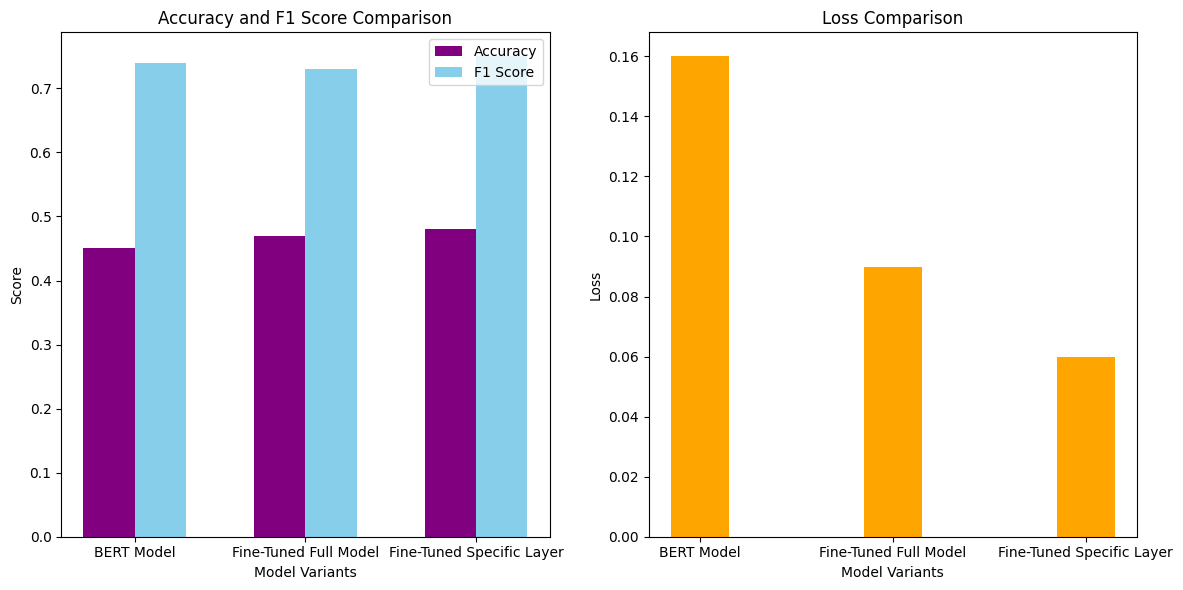

In [ ]:
# Comparision between model's result
import matplotlib.pyplot as plt
import numpy as np

# Example metrics for each model (replace with actual results)
model_variants = ['BERT Model', 'Fine-Tuned Full Model', 'Fine-Tuned Specific Layer']
accuracies = [0.45, 0.47, 0.48]
f1_scores = [0.74, 0.73, 0.75]
losses = [0.16, 0.09, 0.06]

# Set up positions for bar groups
x = np.arange(len(model_variants))
width = 0.3  # Width of bars

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot Accuracy and F1 Score Comparison
ax[0].bar(x - width/2, accuracies, width, label='Accuracy', color='purple')
ax[0].bar(x + width/2, f1_scores, width, label='F1 Score', color='skyblue')
ax[0].set_title('Accuracy and F1 Score Comparison')
ax[0].set_xlabel('Model Variants')
ax[0].set_ylabel('Score')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_variants)
ax[0].legend()

# Plot Loss Comparison
ax[1].bar(x, losses, width, label='Loss', color='orange')
ax[1].set_title('Loss Comparison')
ax[1].set_xlabel('Model Variants')
ax[1].set_ylabel('Loss')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_variants)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Performance testing (Fine tune model)

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load model and tokenizer
def load_trained_model_and_tokenizer(model_path, tokenizer_name, device):
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels=5)
    tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model, tokenizer

In [ ]:
# Predict emotions for a single text
def predict_emotions(text, model, tokenizer, emotion_labels, device):
    encoded_input = tokenizer(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    input_ids = encoded_input["input_ids"].to(device)
    attention_mask = encoded_input["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze().cpu()
        probabilities = torch.sigmoid(logits).numpy()  # Convert logits to probabilities
        binary_outputs = probabilities >= 0.5  # Binary classification (threshold = 0.5)

    return binary_outputs.astype(int), probabilities

In [ ]:
# Process the test CSV and generate results
def process_test_file(test_file, model, tokenizer, emotion_labels, device, output_file):
    # Read the test CSV file
    df = pd.read_csv(test_file)

    # Ensure the column containing the text is named correctly (e.g., 'text')
    if 'text' not in df.columns:
        raise ValueError("The input CSV must contain a 'text' column.")

    # Prepare lists to store outputs
    binary_results = []
    probabilities_results = []

    # Iterate over each row in the DataFrame
    for text in df['text']:
        binary_output, probabilities = predict_emotions(text, model, tokenizer, emotion_labels, device)
        binary_results.append(binary_output)
        probabilities_results.append(probabilities)

    # Add binary results to the DataFrame
    for idx, label in enumerate(emotion_labels):
        df[f"{label}"] = [row[idx] for row in binary_results]

    # Save the results to the output file
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

# Define parameters
MODEL_PATH = "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_layer"  # Path to your trained model
TOKENIZER_NAME = "bert-base-uncased"  # Tokenizer name
TEST_FILE = "./drive/MyDrive/ColabNotebooks/semeval_project/eng_a_dev.csv"  # Input test file
OUTPUT_FILE = "tested_op.csv"  # Output results file
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define emotion labels
EMOTION_LABELS = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

# Main execution
if __name__ == "__main__":
    # Load the model and tokenizer
    model, tokenizer = load_trained_model_and_tokenizer(MODEL_PATH, TOKENIZER_NAME, DEVICE)

    # Process the test file and generate results
    process_test_file(TEST_FILE, model, tokenizer, EMOTION_LABELS, DEVICE, OUTPUT_FILE)


Results saved to tested_op.csv


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
import random

# Load model and tokenizer
def load_trained_model_and_tokenizer(model_path, tokenizer_name, device):
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels=5)
    tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model, tokenizer

# Predict emotions for a single text
def predict_emotions(text, model, tokenizer, emotion_labels, device):
    encoded_input = tokenizer(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    input_ids = encoded_input["input_ids"].to(device)
    attention_mask = encoded_input["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze().cpu()
        probabilities = torch.sigmoid(logits).numpy()  # Convert logits to probabilities
        binary_outputs = probabilities >= 0.5  # Binary classification (threshold = 0.5)

    return binary_outputs.astype(int), probabilities

# Process the test CSV and generate results
def process_test_file(test_file, model, tokenizer, emotion_labels, device, output_file):
    # Read the test CSV file
    df = pd.read_csv(test_file)

    # Ensure the column containing the text is named correctly (e.g., 'text')
    if 'text' not in df.columns:
        raise ValueError("The input CSV must contain a 'text' column.")

    # Prepare lists to store outputs
    binary_results = []
    probabilities_results = []

    # Iterate over each row in the DataFrame
    for text in df['text']:
        binary_output, probabilities = predict_emotions(text, model, tokenizer, emotion_labels, device)
        binary_results.append(binary_output)
        probabilities_results.append(probabilities)

    # Add binary results to the DataFrame
    for idx, label in enumerate(emotion_labels):
        df[f"{label}"] = [row[idx] for row in binary_results]

    # Save the results to the output file
    df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

    return df, binary_results, probabilities_results

# Function to plot the predictions with better visualization
def plot_predictions(df, binary_results, emotion_labels, num_samples=20):
    # Select `num_samples` random rows for visualization
    random_indices = random.sample(range(len(df)), num_samples)
    random_texts = df['text'].iloc[random_indices].values
    emotion_predictions = np.array(binary_results)[random_indices]

    # Create a horizontal bar chart with color coding
    fig, axes = plt.subplots(nrows=num_samples, ncols=1, figsize=(10, 2*num_samples))
    colors = ['#FF6347', '#1E90FF', '#98FB98', '#FFD700', '#D2691E']  # Emotion color scheme

    for i in range(num_samples):
        ax = axes[i]
        ax.barh(emotion_labels, emotion_predictions[i], color=colors)
        ax.set_title(f"Text {i+1}: {random_texts[i][:100]}...")  # Show first 100 chars of the text
        ax.set_xlim([0, 1])  # Binary classification: 0 or 1
        ax.set_xlabel('Prediction')

        # Adding a grid to improve readability
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Define parameters
MODEL_PATH = "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_layer"  # Path to your trained model
TOKENIZER_NAME = "bert-base-uncased"  # Tokenizer name
TEST_FILE = "./drive/MyDrive/ColabNotebooks/semeval_project/eng_a_dev.csv"  # Input test file
OUTPUT_FILE = "test_results.csv"  # Output results file
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define emotion labels
EMOTION_LABELS = ['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']

# Main execution
if __name__ == "__main__":
    # Load the model and tokenizer
    model, tokenizer = load_trained_model_and_tokenizer(MODEL_PATH, TOKENIZER_NAME, DEVICE)

    # Process the test file and generate results
    df, binary_results, probabilities_results = process_test_file(TEST_FILE, model, tokenizer, EMOTION_LABELS, DEVICE, OUTPUT_FILE)

    # Plot the predictions for the randomly selected 15-20 samples
    plot_predictions(df, binary_results, EMOTION_LABELS, num_samples=20)




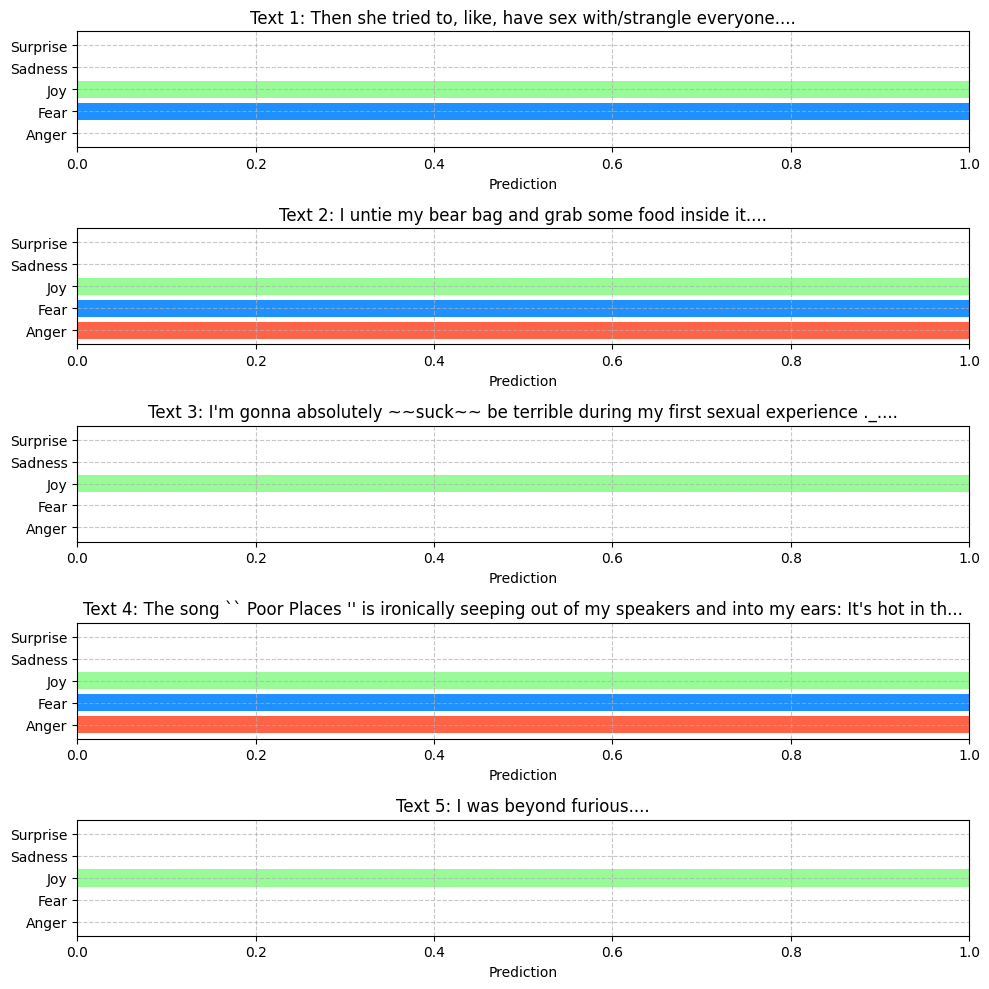

In [ ]:
    # Plot the predictions for the randomly selected 15-20 samples
    plot_predictions(df, binary_results, EMOTION_LABELS, num_samples=5)

In [ ]:
def process_test_file(test_file, model, tokenizer, emotion_labels, device):
    # Read the test CSV file
    df = pd.read_csv(test_file)

    # Ensure the column containing the text and labels is named correctly
    if 'text' not in df.columns or not all(label in df.columns for label in emotion_labels):
        raise ValueError("The input CSV must contain a 'text' column and columns for each emotion label.")

    # Handle NaN values in emotion labels by replacing them with 0
    df[emotion_labels] = df[emotion_labels].fillna(0).astype(int)

    # Prepare lists to store outputs and ground truth labels
    predictions = []
    ground_truths = df[emotion_labels].values  # Extract ground truth labels for all emotions

    # Iterate over each row in the DataFrame
    for text in df['text']:
        binary_output = predict_emotions(text, model, tokenizer, device)
        predictions.append(binary_output)

    return df, predictions, ground_truths


Text: with an infant stroller and backup i had my hands full and i needed time to do things
True Labels: [0 1 0 0 0]
Predicted Labels: [1 1 1 0 0]


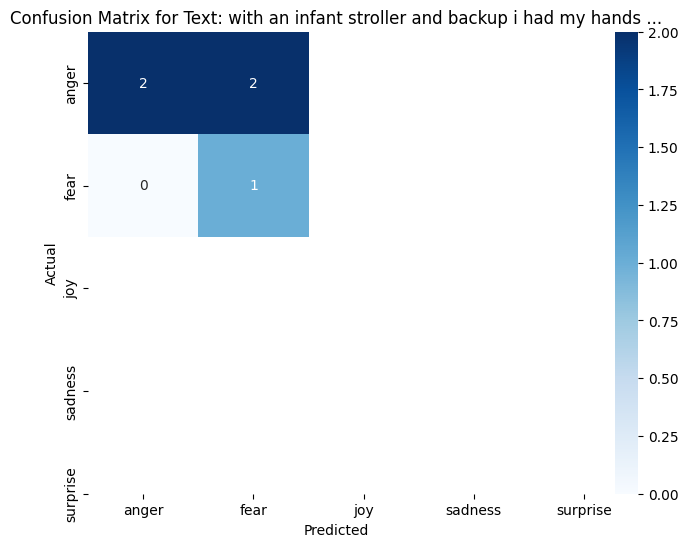

Classification Report for Each Emotion:

Emotion: anger

Emotion: fear

Emotion: joy

Emotion: sadness

Emotion: surprise
Unique values for y_true: [0]
Unique values for y_pred: [0]
Text: the asphalt was so hot it had burned the balls of my feet to the point of blistering from standing on it
True Labels: [1 1 0 0 0]
Predicted Labels: [1 0 1 0 0]


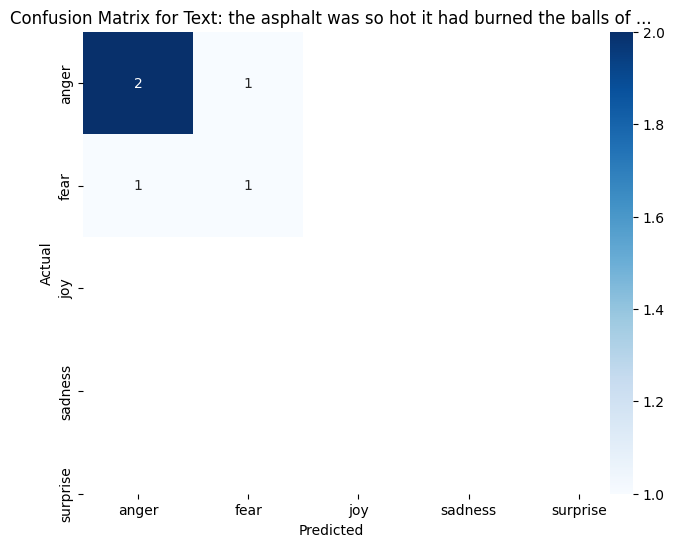

Classification Report for Each Emotion:

Emotion: anger

Emotion: fear

Emotion: joy

Emotion: sadness

Emotion: surprise
Unique values for y_true: [0]
Unique values for y_pred: [0]
Text: it looks like dark smelly applesauce
True Labels: [0 1 0 0 1]
Predicted Labels: [1 0 0 0 0]


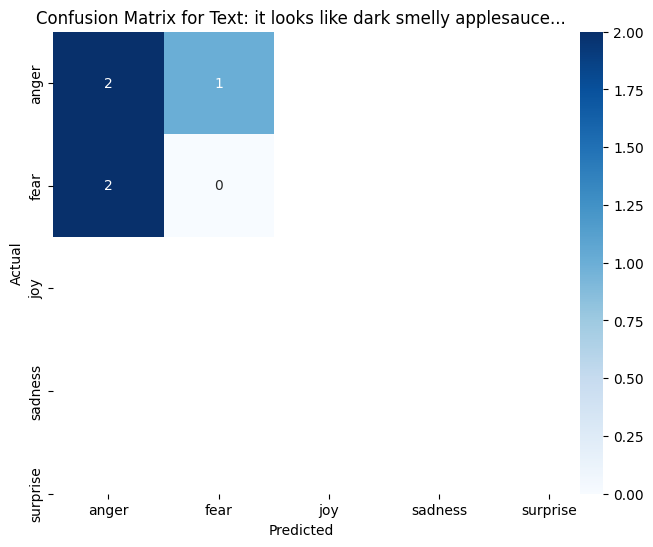

Classification Report for Each Emotion:

Emotion: anger

Emotion: fear

Emotion: joy

Emotion: sadness

Emotion: surprise
Unique values for y_true: [1]
Unique values for y_pred: [0]
Text: i grinned looking at the saddened ceres from the corner of my eye
True Labels: [0 0 1 0 0]
Predicted Labels: [1 0 0 0 0]


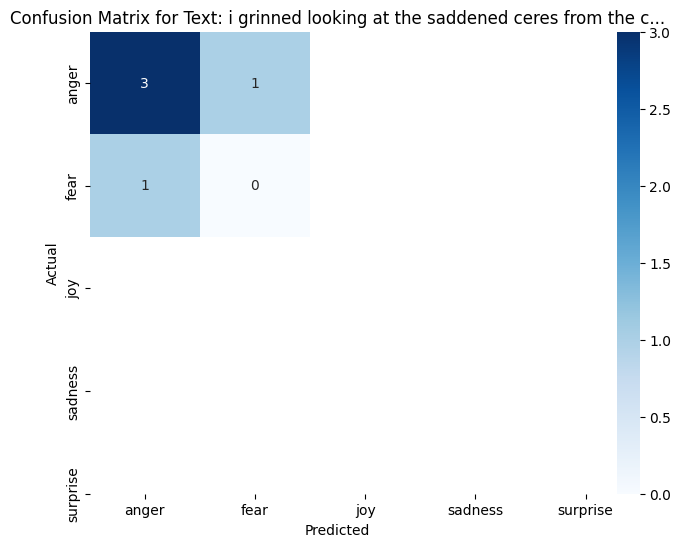

Classification Report for Each Emotion:

Emotion: anger

Emotion: fear

Emotion: joy

Emotion: sadness

Emotion: surprise
Unique values for y_true: [0]
Unique values for y_pred: [0]
Text: my mouth by then like cardboard
True Labels: [0 0 0 0 0]
Predicted Labels: [1 0 1 0 0]


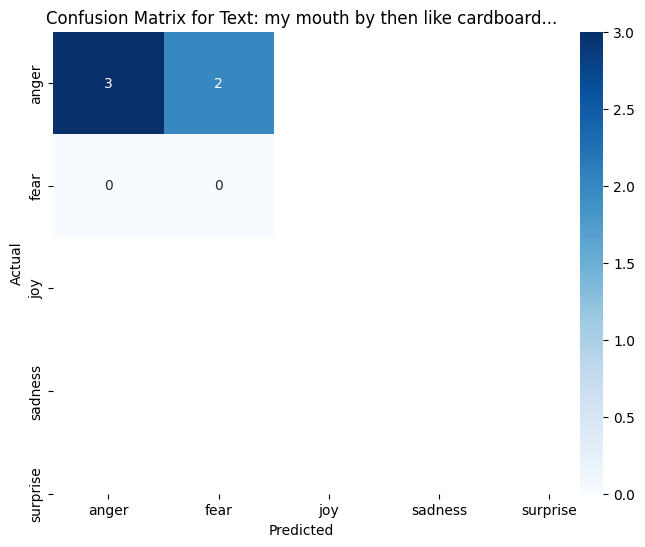

Classification Report for Each Emotion:

Emotion: anger

Emotion: fear

Emotion: joy

Emotion: sadness

Emotion: surprise
Unique values for y_true: [0]
Unique values for y_pred: [0]


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load model and tokenizer
def load_trained_model_and_tokenizer(model_path, tokenizer_name, device):
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels= 5)
    tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model, tokenizer

# Predict emotions for a single text
def predict_emotions(text, model, tokenizer, device):
    encoded_input = tokenizer(text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
    input_ids = encoded_input["input_ids"].to(device)
    attention_mask = encoded_input["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze().cpu()
        probabilities = torch.sigmoid(logits).numpy()  # Convert logits to probabilities
        binary_outputs = probabilities >= 0.5  # Binary classification (threshold = 0.5)

    return binary_outputs.astype(int)

    print("Shape of y_true:", y_true.shape)
    print("Shape of y_pred:", y_pred.shape)


# Process the test CSV and generate predictions
def process_test_file(test_file, model, tokenizer, emotion_labels, device):
    # Read the test CSV file
    df = pd.read_csv(test_file)

    # Ensure the column containing the text and labels is named correctly
    if 'text' not in df.columns or not all(label in df.columns for label in emotion_labels):
        raise ValueError("The input CSV must contain a 'text' column and columns for each emotion label.")

    # Prepare lists to store outputs and ground truth labels
    predictions = []
    ground_truths = df[emotion_labels].values  # Extract ground truth labels for all emotions

    # Iterate over each row in the DataFrame
    for text in df['text']:
        binary_output = predict_emotions(text, model, tokenizer, device)
        predictions.append(binary_output)

    return df, predictions, ground_truths

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, emotion_labels, text):
    cm = confusion_matrix(y_true, y_pred)

    # Plot using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title(f"Confusion Matrix for Text: {text[:50]}...")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Generate classification report
def generate_classification_report(y_true, y_pred, emotion_labels):
    """
    Generates classification reports for each emotion label.
    Handles both 1D and 2D arrays.
    """
    print("Classification Report for Each Emotion:")

    # Ensure y_true and y_pred are numpy arrays for consistent indexing
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle 1D arrays (if needed, reshape to 2D for multi-label classification)
    if len(y_true.shape) == 1:
        y_true = y_true.reshape(-1, len(emotion_labels))
    if len(y_pred.shape) == 1:
        y_pred = y_pred.reshape(-1, len(emotion_labels))

    # Generate reports for each emotion
    for idx, emotion in enumerate(emotion_labels):
        print(f"\nEmotion: {emotion}")
        # Extract predictions and true labels for the current emotion
        y_true_emotion = y_true[:, idx]
        y_pred_emotion = y_pred[:, idx]

        # Check if y_true or y_pred has only a single class
        if len(np.unique(y_true_emotion)) == 1 or len(np.unique(y_pred_emotion)) == 1:
            print(f"Warning: Only one class present in y_true or y_pred for emotion '{emotion}'. Skipping.")
            continue

        # Generate and print classification report
        report = classification_report(
            y_true_emotion,
            y_pred_emotion,
            target_names=["Not " + emotion, emotion],
        )
        print(report)

    print("Unique values for y_true:", np.unique(y_true[:, idx]))
    print("Unique values for y_pred:", np.unique(y_pred[:, idx]))

# Main function to visualize confusion matrices and classification reports
def visualize_confusion_matrix_and_report(test_file, model, tokenizer, emotion_labels, device, num_samples=5):
    # Process the test file
    df, predictions, ground_truths = process_test_file(test_file, model, tokenizer, emotion_labels, device)

    # Randomly select `num_samples` texts
    random_indices = random.sample(range(len(df)), num_samples)

    for idx in random_indices:
        text = df['text'].iloc[idx]
        y_true = ground_truths[idx]
        y_pred = predictions[idx]

        print(f"Text: {text}")
        print(f"True Labels: {y_true}")
        print(f"Predicted Labels: {y_pred}")

        # Plot confusion matrix
        plot_confusion_matrix(y_true, y_pred, emotion_labels, text)

        # Generate classification report
        generate_classification_report(y_true, y_pred, emotion_labels)

# Define parameters
MODEL_PATH = "./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_layer"  # Path to your trained model
TOKENIZER_NAME = "bert-base-uncased"  # Tokenizer name
TEST_FILE = "./drive/MyDrive/ColabNotebooks/semeval_project/test_data.csv"  # Input test file
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define emotion labels
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']

# Main execution
if __name__ == "__main__":
    # Load the model and tokenizer
    model, tokenizer = load_trained_model_and_tokenizer(MODEL_PATH, TOKENIZER_NAME, DEVICE)

    # Visualize confusion matrix and classification report for random samples
    visualize_confusion_matrix_and_report(TEST_FILE, model, tokenizer, emotion_labels, DEVICE, num_samples=5)




In [ ]:
# Streamlit app to show the output
%pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok --quiet

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("2qypZIor5t5E3p03PkB3LJ1a18p_n3RfJchPKjEALkaXCcvJ")  # Replace with your actual authtoken

In [ ]:
!streamlit run /content/streamlit_app.py &>/content/logs.txt &

In [ ]:
# App with sidebar
import streamlit as st
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd


from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model.save_pretrained(r"./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_layer")
tokenizer.save_pretrained(r"./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_layer")


# Load the trained BERT model and tokenizer
@st.cache_resource
def load_model_and_tokenizer():
    model_path = r"./drive/MyDrive/ColabNotebooks/semeval_project/emotion_classification_model_finetune_layer"
    model = BertForSequenceClassification.from_pretrained(model_path, num_labels=5)
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model.eval()
    return model, tokenizer

st.write("Loading model...")
try:
    model, tokenizer = load_model_and_tokenizer()
    st.write("Model and tokenizer loaded successfully.")
except Exception as e:
    st.error(f"Error loading model: {e}")


model, tokenizer = load_model_and_tokenizer()

# Define emotion labels
emotion_labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']

# Function to predict emotions for a given text
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    predicted_label_index = probabilities.argmax()
    predicted_label = emotion_labels[predicted_label_index]
    return predicted_label, probabilities

# Streamlit Sidebar
st.sidebar.title("Navigation")
app_mode = st.sidebar.radio(
    "Choose an option:",
    ["Test Single Text", "Test CSV File"]
)

st.sidebar.title("About")
st.sidebar.info(
    """
    **Emotion Detection with BERT**
    This application predicts the emotion of a given text using a fine-tuned BERT model.
    Developed with 🧡 using [Streamlit](https://streamlit.io) and [Transformers](https://huggingface.co/transformers/).
    """
)

# Main App Logic
if app_mode == "Test Single Text":
    st.title("Emotion Detection - Single Text")
    st.write("Enter a piece of text to detect its emotion.")

    input_text = st.text_area("Enter your text:")
    if st.button("Predict Emotion"):
        if input_text.strip():
            predicted_emotion, probabilities = predict_emotion(input_text)
            st.write(f"**Predicted Emotion:** {predicted_emotion}")
            st.write("**Confidence Scores:**")
            for label, prob in zip(emotion_labels, probabilities):
                st.write(f"{label}: {prob:.4f}")

elif app_mode == "Test CSV File":
    st.title("Emotion Detection - CSV File")
    st.write("Upload a CSV file with a column named 'text' to detect emotions for each entry.")

    uploaded_file = st.file_uploader("Upload a CSV file", type=["csv"])
    if uploaded_file:
        test_data = pd.read_csv(uploaded_file)
        if 'text' in test_data.columns:
            test_data['predicted_emotion'] = test_data['text'].apply(lambda x: predict_emotion(x)[0])
            st.write("Predictions:")
            st.dataframe(test_data[['text', 'predicted_emotion']])
            st.download_button(
                label="Download Predictions as CSV",
                data=test_data.to_csv(index=False).encode('utf-8'),
                file_name="predictions.csv",
                mime="text/csv",
            )
        else:
            st.error("Uploaded CSV must contain a 'text' column.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-12-31 11:36:27.849 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-31 11:36:27.851 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-31 11:36:27.855 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-31 11:36:27.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-31 11:36:27.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-31 11:36:27.861 Thread 'MainThread': missing ScriptRunContext! This w